# Feature Selection for Springflow Prediction
##### By Emily Pease, UT Austin
##### 11/18/2019

The Edwards Aquifer Authority (EAA) and all stakeholders need accurate and current springflow data in order to make informed decisions for Comal Springs, especially during drought periods when the endangered species that inhabit the springs are most at risk due to low water levels \cite{lizards}.  However, springflow is difficult to measure directly due to the complexity of numerous seeps and spring orifices and the intermittent presence of rainfall and runoff.  The U.S. Geological Survey (USGS) is the federal agency responsible for correctly measuring the daily spring discharge and the EAA is responsible for regulating discharge through groundwater pumping or withdrawal to ensure the springs are flowing above drought thresholds.  

The current method used by the USGS for measuring springflow at Comal Springs involves separating the springflow component from the streamflow, otherwise referred to as baseflow separation or hydrograph separation \cite{wahl1995determining}.  This method includes some manual estimation of springflow, making this method's results often subjective and time-consuming.  The USGS often needs up to three months to publicly release springflow estimates, though the EAA and other water resource managers need to make daily water use decisions, especially when the aquifer levels are close to drought stage thresholds.  Additionally, these springs are primarily modeled by the EAA using theory-based models to simulate pumping scenarios and drought scenarios.  Here, a springflow prediction model was created using a theory-guided data science approach as a viable option for water resource management. 


### Methods used for feature ranking here include:
1. Summary statistics
2. Visual inspection of scatter matrices and heat maps
3. Correlation coefficients
4. Model-based (LASSO)
5. Domain expertise

### Dataset Description

When performing statistical learning methods on big data, there is often a precompiled dataset containing all parameters for analysis. Here, there was no master dataset of all Edwards Aquifer data and all data used in this study were individually accessed from their respective agencies and  preprocessed prior to model runs.  The individual features selected to be included in the comprehensive Edwards Aquifer dataset are from the EAA, USGS, and National Oceanic and Atmospheric Administration (NOAA).  The time frame for this study is from 1950-01-01 to present using daily data that captures the two major droughts in recent history (1950-1956, 2011-2014). 

Predictor features:
1. J-17: Bexar County index well, located 24 miles from Comal Springs (EAA)
2. J-27: Uvalde County index well, located 106 miles from Comal Springs (EAA)
3. Q$_{riv}$: Comal River discharge ($\frac{ft^3}{s}$) recorded on 15-minute intervals that were then averaged together (USGS)
4. T$_{max}$: maximum recorded daily temperature (NOAA)
5. T$_{min}$: minimum recorded daily temperature (NOAA)
6. $\Delta$ T: daily change in temperature (T$_{max}-$T$_{min}$) (NOAA)
7. P$_{RM}$: trailing rolling mean of preciptiation (t=3 days) (NOAA)

Response feature:
1. Q$_{spg}$: Comal Springs daily mean discharge (USGS)

In [12]:
import os                                                
import numpy as np                                          
import scipy.stats as st                                    
import pandas as pd                                         
import matplotlib.pyplot as plt                             
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import train_test_split        
from sklearn.metrics import explained_variance_score
from sklearn.linear_model import Lasso
import seaborn as sns 
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.diagnostic import het_goldfeldquandt
import pandas as pd
from itertools import repeat
import statsmodels.api as sm
from statsmodels.formula.api import ols
import warnings

warnings.filterwarnings("ignore")
plt.style.use('ggplot')

In [2]:
df = pd.read_csv(os.path.join("..", "data", "ComalPrecipRolling.csv"))
df['datetime'] = pd.to_datetime(df["datetime"])
df = df[df["RvQ"] < 800] # Truncate to remove outliers
# df = df[df["rolling_mean"] > 0.003333] # remove non-impactful precipitation events
df.describe().T

,count,mean,std,min,25%,50%,75%,max
J17Level,23806.0,663.106758,17.412718,612.51,6.509518e+02,664.700000,676.350000,703.3100
J27Level,23806.0,866.982184,16.239798,810.95,8.637000e+02,872.350000,877.427500,889.0500
RvQ,23806.0,281.183928,99.758292,5.50,2.180000e+02,290.000000,347.000000,793.0000
PRCP,23806.0,0.083444,0.275042,0.00,0.000000e+00,0.000000,0.018000,6.5025
TMAX,23806.0,78.113606,14.283710,6.00,6.900000e+01,80.000000,90.000000,109.0000
TMIN,23806.0,53.491305,15.224070,-1.00,4.100000e+01,56.000000,67.000000,84.0000
DeltaT,23806.0,24.622301,8.866411,-40.00,1.900000e+01,24.000000,31.000000,69.0000
SpgQ,23806.0,276.229584,94.605440,0.00,2.150000e+02,290.000000,345.000000,513.0000
rolling_mean,23806.0,0.086904,0.200649,0.00,2.826443e-15,0.003333,0.075556,4.1800
RvSpgDiff,23806.0,0.062501,0.769731,0.00,0.000000e+00,0.000000,0.000000,16.0000


In [3]:
X = df.iloc[:, 1]
y = df.iloc[:, -3]

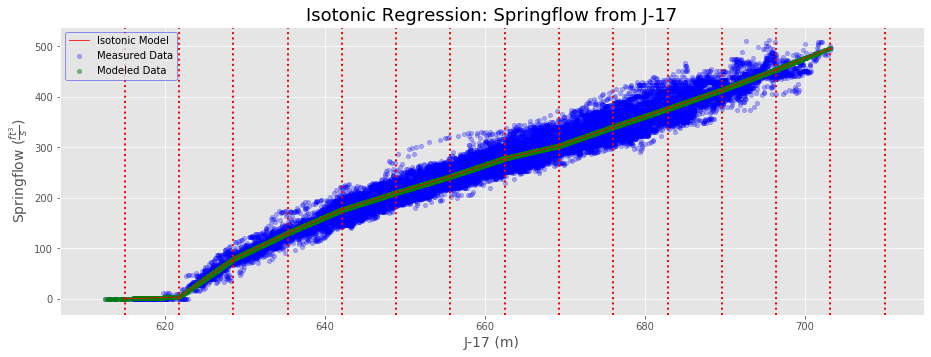

In [4]:
iso_reg = IsotonicRegression().fit(X, y)
X_predict = np.linspace(615,710,15)
y_predict = iso_reg.predict(X_predict)
y_predict_test = np.interp(X, X_predict, y_predict, left=None, right=None, period=None)

# Plot test predictions
plt.subplot(111)
plt.scatter(X, y,  color='blue', s = 20, alpha = 0.3, label='Measured Data')
plt.scatter(X, y_predict_test,  color='green', s = 20, alpha = 0.5, label='Modeled Data')
plt.plot(X_predict, y_predict, color='red', linewidth=.8, label='Isotonic Model')
for threshold in X_predict:
    plt.axvline(threshold, color='red', linewidth=2, linestyle=':', alpha = 1)
plt.title('Isotonic Regression: Springflow from J-17', size=18); 
plt.xlabel('J-17 (m)', size=14); plt.ylabel(r'Springflow ($\frac{ft^3}{s}$)', size=14)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
leg = plt.legend()
leg.get_frame().set_edgecolor('b')

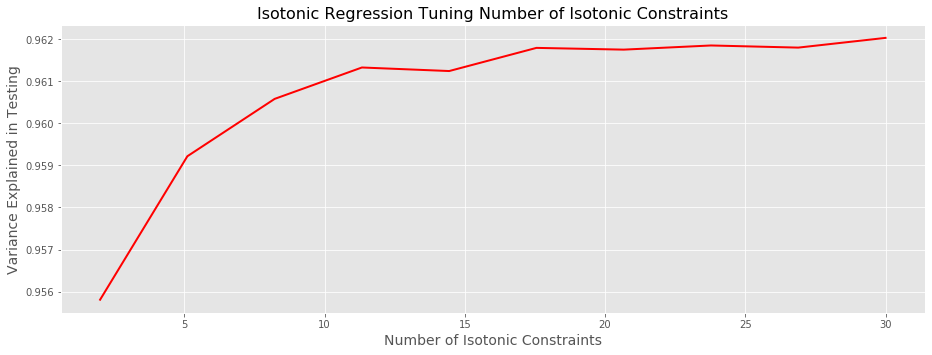

In [5]:
isotonic_constraint_list = np.linspace(2,30,10)
r2 = []

for k in isotonic_constraint_list:
    X_predict = np.linspace(615, 700, k)
    iso_reg = IsotonicRegression().fit(X, y)
    y_predict = iso_reg.predict(X_predict)
    y_predict_test = np.interp(X, X_predict, y_predict, left=None, right=None, period=None)
    r2.append(explained_variance_score(y, y_predict_test))

plt.subplot(111)
plt.plot(isotonic_constraint_list, r2, color='red', linewidth=2, label='model')
plt.title('Isotonic Regression Tuning Number of Isotonic Constraints', size=16);
plt.xlabel('Number of Isotonic Constraints', size=14); plt.ylabel('Variance Explained in Testing', size=14)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)

(-10, 515)

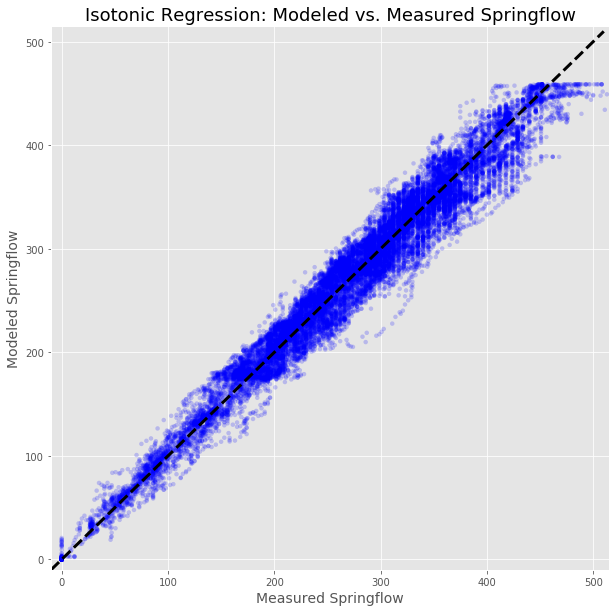

In [6]:
y_predict_test = np.interp(X, X_predict, y_predict, left=None, right=None, period=None)

fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(y, y_predict_test, alpha=0.2, edgecolor='', color='blue', s=20)
plt.plot(np.linspace(-10,510,10), np.linspace(-10,510,10), '--k', linewidth=3)
plt.title('Isotonic Regression: Modeled vs. Measured Springflow', size=18); 
plt.xlabel('Measured Springflow', size=14); plt.ylabel(r'Modeled Springflow', size=14)
plt.xlim(-10, 515); plt.ylim(-10,515)

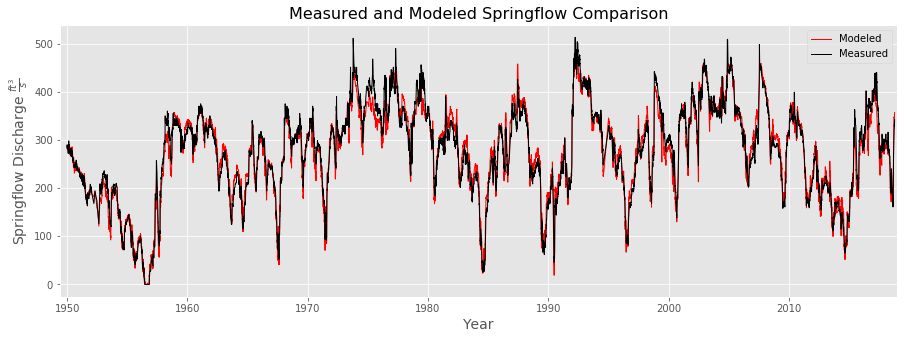

In [7]:
fig, ax = plt.subplots(figsize=(15,5))

ax.plot(df['datetime'], y_predict_test, color='red',   linestyle='-', linewidth=1, alpha=1, label='Modeled')
ax.plot(df['datetime'],   df["SpgQ"],   color='black', linestyle='-', linewidth=1, alpha=1, label='Measured')

plt.title("Measured and Modeled Springflow Comparison", size=16)
plt.xlabel("Year", size=14); plt.ylabel(r"Springflow Discharge $\frac{ft^3}{s}$", size=14)
plt.xlim("1949-06-01", "2019-01-01")
plt.legend()

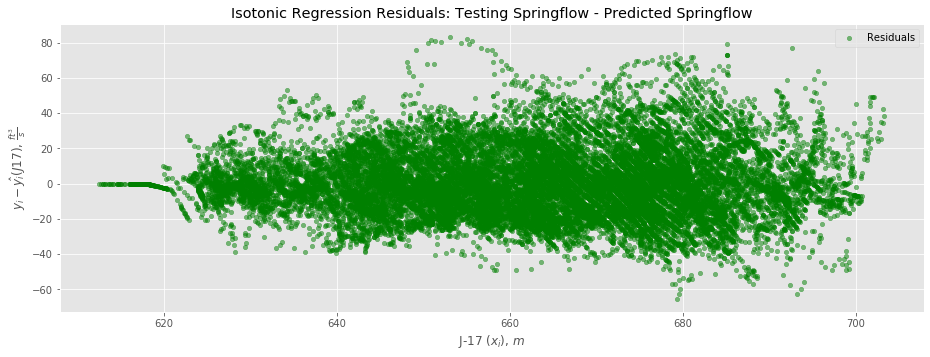

In [8]:
residuals = y-y_predict_test
df["Residual"] = residuals
df["Spg_IsoPred"] = y_predict_test

plt.subplot(111)
plt.scatter(X, residuals,  color='green', s = 20, alpha = 0.5, label='Residuals')
plt.title('Isotonic Regression Residuals: Testing Springflow - Predicted Springflow'); 
plt.xlabel(r'J-17 ($x_i$), $m$'); plt.ylabel(r'$y_i-\hat{y_i}(J17)$, $\frac{ft^3}{s}$')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
plt.legend()

(711644.0, 737060.0)

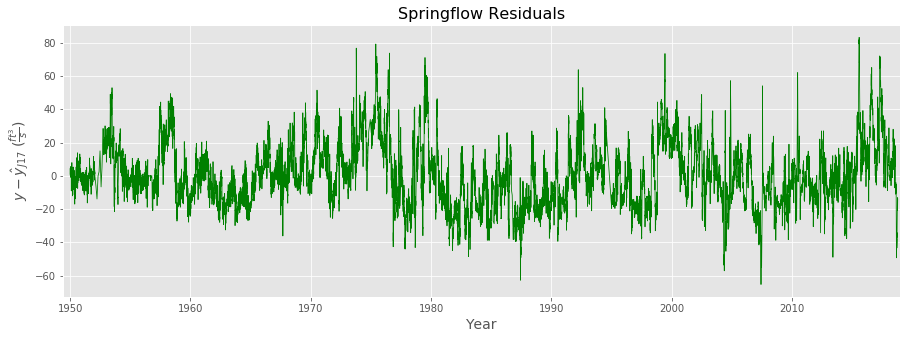

In [9]:
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(df['datetime'], df["Residual"], color='g', linewidth=0.8)
plt.xlabel("Year", size=14); plt.ylabel(r'$y-\hat{y}_{J17}$ ($\frac{ft^3}{s}$)', size=14)
plt.title("Springflow Residuals", size=16)
plt.xlim("1949-06-01", "2019-01-01")

In [10]:
X_predict0 = X_predict.tolist()
X_predict0 = [0]+X_predict0
X_predict = list(X_predict)

In [13]:
mins = [];maxs = [];P1s  = [];P5s  = [];P10s = [];P25s = [];P35s = [];P50s = [];P65s = [];P75s = [];
P90s = [];P95s = []; P99s = [];preds_in_df = []

mins_ = []
maxs_ = []

temp_df = df[df["J17Level"] <= X_predict0[1]]
temp_df['diff'] = temp_df["SpgQ"] - temp_df["Spg_IsoPred"]
preds_in_df.extend(repeat(X_predict0[0], len(temp_df)))
P25 = np.percentile(temp_df["diff"], 25)
P75 = np.percentile(temp_df["diff"], 75)
mins_.extend(repeat(P25, len(temp_df)))
maxs_.extend(repeat(P75, len(temp_df)))

for i in range(1, len(X_predict0)-1):
    temp_df = df[(df["J17Level"] > X_predict0[i]) & (df["J17Level"] <= X_predict0[i+1])]
    temp_df['diff'] = temp_df["SpgQ"] - temp_df["Spg_IsoPred"]
    preds_in_df.extend(repeat(X_predict0[i+1], len(temp_df)))
    P1  = np.percentile(temp_df["diff"], 1);  P1s.append(P1)
    P5  = np.percentile(temp_df["diff"], 5);  P5s.append(P5)
    P10 = np.percentile(temp_df["diff"], 10); P10s.append(P10)
    P25 = np.percentile(temp_df["diff"], 25); P25s.append(P25)
    P50 = np.percentile(temp_df["diff"], 50); P50s.append(P50)
    P75 = np.percentile(temp_df["diff"], 75); P75s.append(P75)
    P90 = np.percentile(temp_df["diff"], 90); P90s.append(P90)
    P95 = np.percentile(temp_df["diff"], 95); P95s.append(P95)
    P99 = np.percentile(temp_df["diff"], 99); P99s.append(P99)
    P35 = np.percentile(temp_df["diff"], 35); P35s.append(P35)
    P65 = np.percentile(temp_df["diff"], 65); P65s.append(P65)
    mins.append(temp_df["diff"].min())
    maxs.append(temp_df["diff"].max())
    mins_.extend(repeat(P25, len(temp_df)))
    maxs_.extend(repeat(P75, len(temp_df)))

temp_df = df[df["J17Level"] > X_predict0[-1]]
temp_df['diff'] = temp_df["SpgQ"] - temp_df["Spg_IsoPred"]
preds_in_df.extend(repeat(X_predict0[-1], len(temp_df)))

P25 = np.percentile(temp_df["diff"], 25)
P75 = np.percentile(temp_df["diff"], 75)
mins_.extend(repeat(P25, len(temp_df)))
maxs_.extend(repeat(P75, len(temp_df)))

In [14]:
df.sort_values(by='J17Level', inplace=True)
df["Xpred"] = preds_in_df
df["Xpred"] = df["Xpred"].astype(int)

new_ls = np.zeros(len(preds_in_df))
new_ls = np.digitize(x=df['J17Level'], bins=X_predict0, right=False)
df["XpredBin"] = new_ls
df['Xpred'] = df.apply(lambda i: X_predict0[i['XpredBin']-1],axis=1)
df["Xpred"] = df["Xpred"].astype(int)

df["Mins"] = mins_
df["Maxs"] = maxs_

,datetime,J17Level,J27Level,RvQ,PRCP,TMAX,TMIN,DeltaT,SpgQ,rolling_mean,RvSpgDiff,Residual,Spg_IsoPred,Xpred,XpredBin,Mins,Maxs
2063,1956-08-17,612.51,816.65,11.0,0.00,96.0,63.0,33.0,0.0,0.000000e+00,11.0,0.000,0.000,0,1,0.000,0.000
2062,1956-08-16,612.74,816.75,10.0,0.00,99.0,67.0,32.0,0.0,0.000000e+00,10.0,0.000,0.000,0,1,0.000,0.000
2061,1956-08-15,613.00,816.75,11.0,0.00,99.0,70.0,29.0,0.0,6.000000e-02,0.0,0.000,0.000,0,1,0.000,0.000
2065,1956-08-19,613.02,816.65,11.0,0.00,97.0,71.0,26.0,0.0,0.000000e+00,11.0,0.000,0.000,0,1,0.000,0.000
2060,1956-08-14,613.20,816.95,11.0,0.00,98.0,67.0,31.0,0.0,6.000000e-02,0.0,0.000,0.000,0,1,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14554,1992-06-16,702.91,884.65,484.0,0.00,90.0,73.0,17.0,484.0,3.441691e-15,0.0,25.125,458.875,700,31,-6.875,30.125
14550,1992-06-12,702.95,884.25,503.0,0.35,90.0,65.0,25.0,494.0,6.041667e-01,0.0,35.125,458.875,700,31,-6.875,30.125
14551,1992-06-13,703.18,884.45,501.0,0.00,90.0,65.0,25.0,501.0,3.216667e-01,0.0,42.125,458.875,700,31,-6.875,30.125
14553,1992-06-15,703.19,884.65,493.0,0.00,88.0,73.0,15.0,493.0,3.441691e-15,0.0,34.125,458.875,700,31,-6.875,30.125


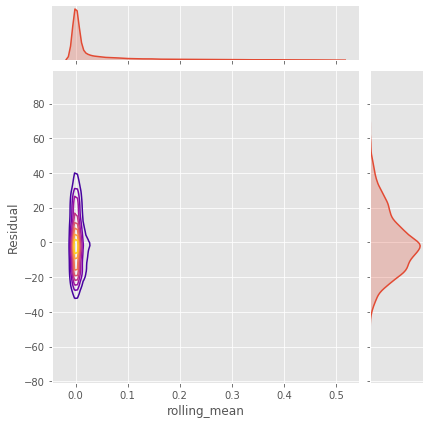

In [36]:
df2 = df[df["rolling_mean"] <0.5]
sns.jointplot(df2['rolling_mean'], df2['Residual'], df2, kind='kde', shade=False, n_levels=10, cmap=cmap)


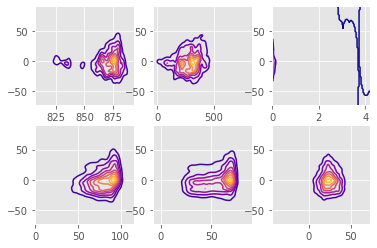

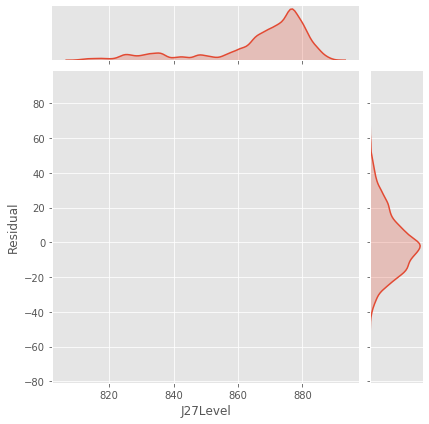

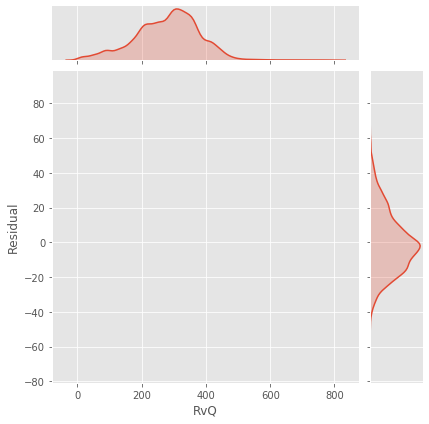

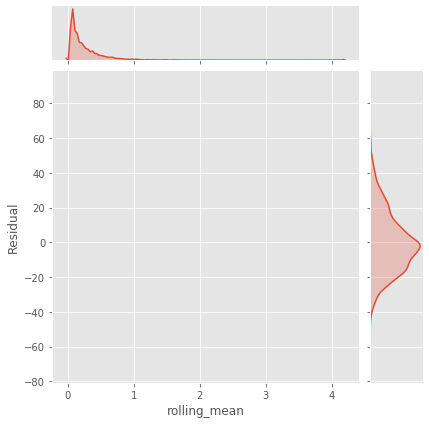

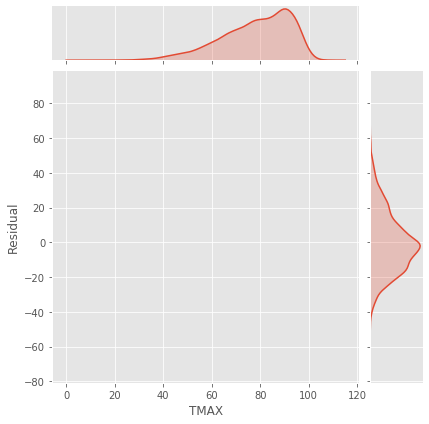

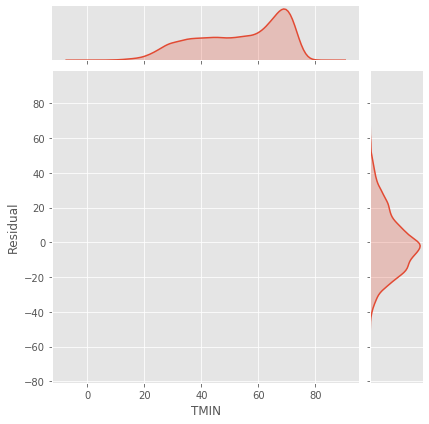

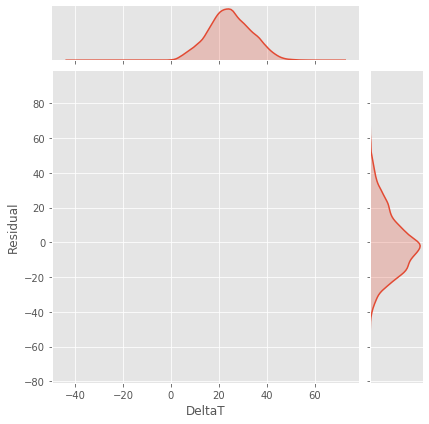

In [31]:
cmap = plt.cm.plasma
f, axes = plt.subplots(2,3)

sns.jointplot(df['J27Level'], df['Residual'], df, kind='kde', shade=False, n_levels=10,cmap=cmap, ax=axes[0,0])
sns.jointplot(df['RvQ'],      df['Residual'], df, kind='kde', shade=False, n_levels=10, cmap=cmap, ax=axes[0,1])
sns.jointplot(df['rolling_mean'], df['Residual'], df, kind='kde', shade=False, n_levels=10, cmap=cmap, ax=axes[0,2])
sns.jointplot(df['TMAX'],   df['Residual'], df, kind='kde',shade=False, n_levels = 10,cmap=cmap, ax=axes[1,0]);
sns.jointplot(df['TMIN'],   df['Residual'], df, kind='kde',shade=False, n_levels = 10,cmap=cmap, ax=axes[1,1]);
sns.jointplot(df['DeltaT'], df['Residual'], df, kind='kde',shade=False, n_levels = 10,cmap=cmap, ax=axes[1,2]);
